# Setup

In [1]:
# Import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plm

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Setup input pipeline

Dataset dir:
```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
# Dowload data (only required for the first time)
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True, cache_dir="~/tensorflow_datasets/")

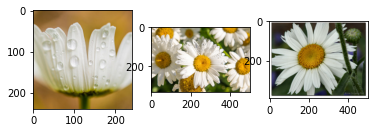

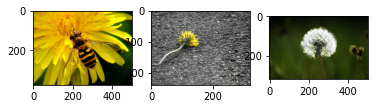

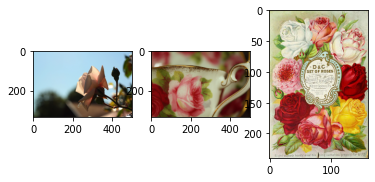

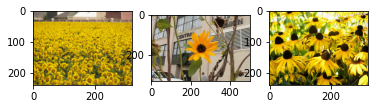

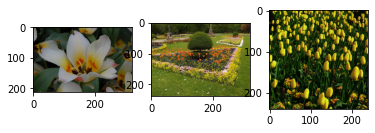

In [4]:
# View first 5 images
directory = os.listdir(data_dir)

for each in ["daisy", "dandelion", "roses", "sunflowers", "tulips"]:
    plt.figure()
    folder = data_dir + "/" + each
    if os.path.isdir(folder):
        for i, file in enumerate(os.listdir(folder)[0:3], start=1):
            fullpath = folder + "/" + file
            img = plm.imread(fullpath)
            plt.subplot(1, 3, i)
            plt.imshow(img)

In [5]:
# Define image size
img_height = 180
img_width = 180

# Create train and validation dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:
# Class labels
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## View train and val dataset 

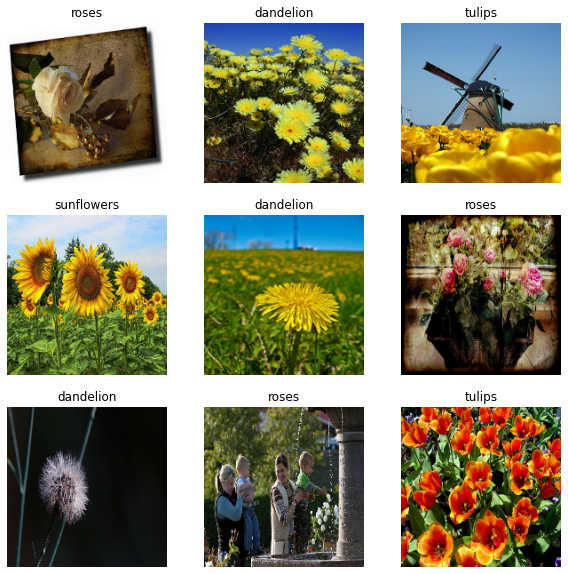

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

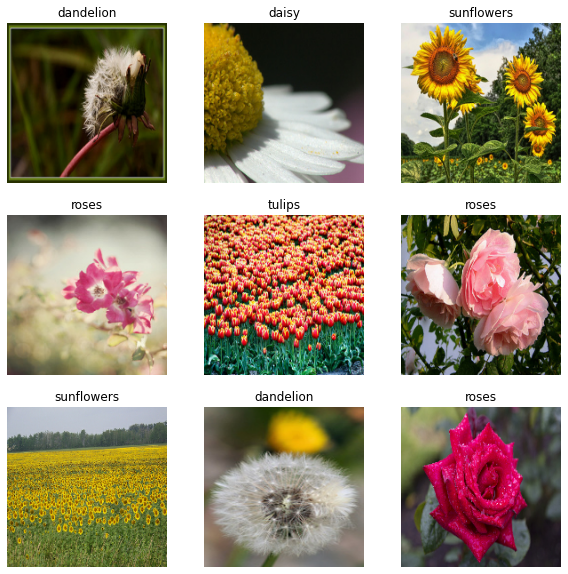

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Configure the dataset for performance

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data normalization layer

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

## Data augmentation layer

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)])

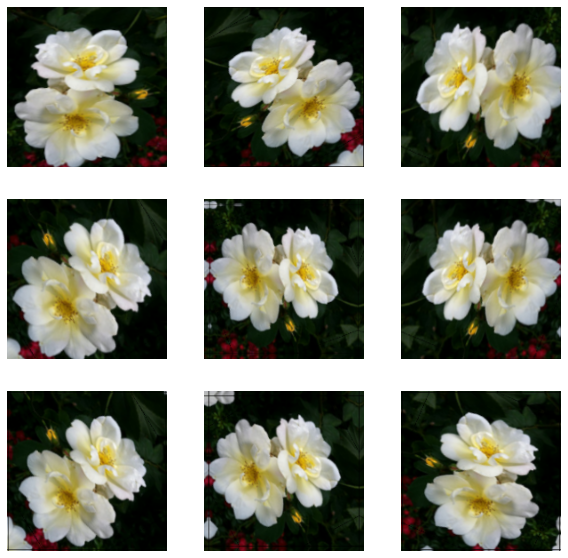

In [12]:
# View a few augmented images for examples
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

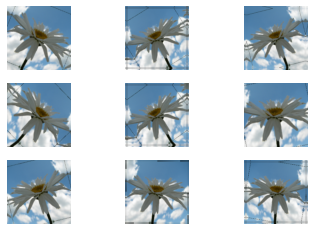

In [13]:
for images, _ in val_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Modelling

In [14]:
model = tf.keras.Sequential([
    data_augmentation, # Data augmentation layer
    layers.experimental.preprocessing.Rescaling(1./255), # Data normalization layer

    # Model
    layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(len(class_names), activation="sigmoid")
])

# Compile model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

# View
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)      

In [15]:
# Create a early stopping hook
callback_hooks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)]

In [16]:
# Train and validate model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callback_hooks)

Epoch 1/100
92/92 [==============================] - 3s 35ms/step - loss: 1.4383 - accuracy: 0.3454 - val_loss: 1.3282 - val_accuracy: 0.3883
Epoch 2/100
92/92 [==============================] - 2s 20ms/step - loss: 1.3190 - accuracy: 0.4281 - val_loss: 1.3046 - val_accuracy: 0.4564
Epoch 3/100
92/92 [==============================] - 2s 20ms/step - loss: 1.3068 - accuracy: 0.4629 - val_loss: 1.3274 - val_accuracy: 0.4741
Epoch 4/100
92/92 [==============================] - 2s 20ms/step - loss: 1.2897 - accuracy: 0.4758 - val_loss: 1.3200 - val_accuracy: 0.4932
Epoch 5/100
92/92 [==============================] - 2s 20ms/step - loss: 1.2971 - accuracy: 0.4847 - val_loss: 1.2812 - val_accuracy: 0.5313
Epoch 6/100
92/92 [==============================] - 2s 20ms/step - loss: 1.2877 - accuracy: 0.4980 - val_loss: 1.2682 - val_accuracy: 0.5150
Epoch 7/100
92/92 [==============================] - 2s 21ms/step - loss: 1.2799 - accuracy: 0.5170 - val_loss: 1.2525 - val_accuracy: 0.5436
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


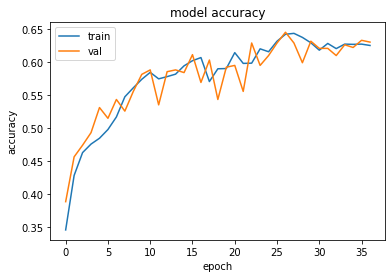

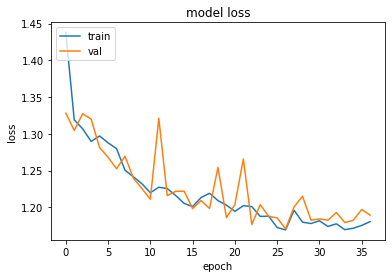

In [17]:
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

# Summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()